In [1]:
# !pip install tensorflow pandas scikit-learn matplotlib pydot -q

In [1]:
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn.preprocessing

from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.7.0


In [3]:
path = r'../../../decipher/datafull.csv'

In [4]:
batch_size = 2 ** 16
seed = 42
print(batch_size)

65536


In [5]:
data = pd.read_csv(path)

In [6]:
data.columns=['source', 'key', 'converted']

In [7]:
data.head()

,source,key,converted
0,aa,1,bb
1,aa,2,cc
2,aa,3,dd
3,aa,4,ee
4,aa,5,ff


In [8]:
y_encoder = sklearn.preprocessing.LabelEncoder()

In [9]:
x = data['converted']
y = data['source']

In [10]:
classes_ = len(y.unique())
print(f'Total classes {classes_}')

Total classes 235839


In [11]:
max_features = classes_ * 300
sequence_length = 32
embedding_dim = 32

In [12]:
y = y_encoder.fit_transform(y)

Make a text-only dataset (without labels), then call adapt

In [13]:
x.to_numpy(), y

(array(['bb', 'cc', 'dd', ..., 'sioha', 'tjpib', 'ukqjc'], dtype=object),
 array([ 25173,  25173,  25173, ..., 235024, 235024, 235024]))

By default `x` is a numpy array with `dtype` as `object`. We change the `dtype` to `string_`

In [15]:
x = np.asarray(x.to_numpy(), dtype=np.string_)

In [16]:
x

array([b'bb', b'cc', b'dd', ..., b'sioha', b'tjpib', b'ukqjc'],
      dtype='|S24')

https://stackoverflow.com/questions/65103526/how-to-save-textvectorization-to-disk-in-tensorflow

In [14]:
vectorize_layer_converted = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)

In [17]:
vectorize_layer_converted.adapt(x)

Saving `vectorize_layer` to cache `adapt`.

In [ ]:
with open('vectorize_layer_weights', 'wb') as file:
    pickle.dump({
        'config': vectorize_layer_converted.get_config(),
        'weights': vectorize_layer_converted.get_weights(),
    }, file)

In [ ]:
def vectorize_text(vectorize_layer, text):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text)[0]

In [ ]:
vectorize_text(vectorize_layer_converted, 'uwwilxuhn')

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([2168,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int64)>

In [ ]:
print(" 10 ---> ",vectorize_layer_converted.get_vocabulary()[10])
print("100 ---> ",vectorize_layer_converted.get_vocabulary()[100])
print('Vocabulary size: {}'.format(len(vectorize_layer_converted.get_vocabulary())))

 10 --->  uwuxygcw
100 --->  yzcjgrc
Vocabulary size: 25898


In [ ]:
x

0               bb
1               cc
2               dd
3               ee
4               ff
            ...   
100994    suugjvwj
100995    tvvhkwxk
100996    uwwilxyl
100997    vxxjmyzm
100998    wyyknzan
Name: converted, Length: 100999, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, shuffle=True, random_state=seed, test_size=0.2,
)

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer_converted,
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(classes_, activation='softmax'),
])

In [ ]:
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.optimizers.Adam(),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)


In [ ]:
# model.summary()

In [ ]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True, show_dtype=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((80799,), (80799,), (20200,), (20200,))

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'model-class({classes_}).h5', monitor='val_sparse_categorical_accuracy',
    verbose=0, save_best_only=True, save_weights_only=False,
    mode='max', save_freq='epoch', namespace_whitelist=["A"],
)

In [ ]:
# 5 epoch for 1 class (5 classes)

epoch_ratio = classes_ * 10

In [ ]:
history = model.fit(
    x_train, y_train, batch_size=batch_size,
    epochs=epoch_ratio, callbacks=[], validation_data=(x_test, y_test),
)

Epoch 1/10000
2/2 [==============================] - 2s 196ms/step - loss: 6.9078 - sparse_categorical_accuracy: 9.1585e-04 - val_loss: 6.9081 - val_sparse_categorical_accuracy: 8.4158e-04
Epoch 2/10000
2/2 [==============================] - 0s 60ms/step - loss: 6.9077 - sparse_categorical_accuracy: 0.0011 - val_loss: 6.9083 - val_sparse_categorical_accuracy: 8.4158e-04
Epoch 3/10000
2/2 [==============================] - 0s 70ms/step - loss: 6.9077 - sparse_categorical_accuracy: 0.0011 - val_loss: 6.9084 - val_sparse_categorical_accuracy: 6.4356e-04
Epoch 4/10000
2/2 [==============================] - 0s 70ms/step - loss: 6.9076 - sparse_categorical_accuracy: 8.9110e-04 - val_loss: 6.9086 - val_sparse_categorical_accuracy: 6.4356e-04
Epoch 5/10000
2/2 [==============================] - 0s 60ms/step - loss: 6.9076 - sparse_categorical_accuracy: 0.0012 - val_loss: 6.9088 - val_sparse_categorical_accuracy: 6.4356e-04
Epoch 6/10000
2/2 [==============================] - 0s 60ms/step - los

In [ ]:
tf.keras.models.save_model(model, f'model{classes_}.tf', save_format='tf')

INFO:tensorflow:Assets written to: model1000.tf\assets


INFO:tensorflow:Assets written to: model1000.tf\assets


In [ ]:
print(f'max_features={max_features},sequence_length={sequence_length},embedding_dim={embedding_dim}')
print(f'max_features_ratio={max_features / classes_}, epoch_ratio={(classes_ * 40) / classes_}')

max_features=300000,sequence_length=32,embedding_dim=32
max_features_ratio=300.0, epoch_ratio=40.0


In [ ]:
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('accuracy', round(acc, 2), 'loss', round(loss, 2))

1/1 [==============================] - 0s 57ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9815
accuracy 0.98 loss 0.09


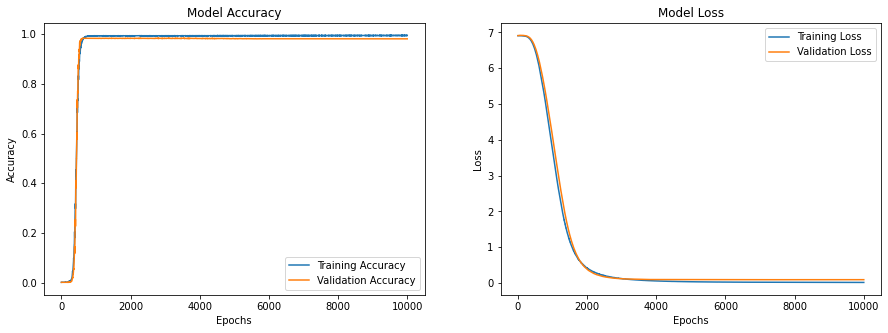

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()